## Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as clrs

import random
import time

from matplotlib import cm
from scipy.stats import zscore
from scipy.stats.stats import pearsonr
from sklearn.decomposition import PCA
from sklearn.decomposition import FastICA
from sklearn.manifold import SpectralEmbedding

import umap

import pickle

## Initial assumptions

In [2]:
# room dimensions in cm. (might break if changed)
width = 140
height = 140


# number of simulated place cells
n_cells = 150

# number of steps inside the environment
minutes = 25
nSteps = minutes * 600
print(str(minutes), "minutes is", str(nSteps), "time bins of 100ms")

# nSteps = 100000

# covariance matrix sigma for place cell class
sigma = np.array([[80, 0],
                  [0, 80]])

25 minutes is 15000 time bins of 100ms


## Place Cell class

In [3]:
# place cell class

class PlaceCell(object):

    def __init__(self, mu, sigma):

        self.mu = mu
        self.sigma = sigma
        
    def gaussian(self, x):

        xm = x - self.mu
        sigma = self.sigma
        
        factor1 = 4            # peak firing rate
        factor2 = (np.exp((-1/2) * xm.T @ np.linalg.inv(sigma) @ xm))
        result = factor1 * factor2
        
        return result
        
    def activity(self, x):
        activity = np.random.poisson(self.gaussian(x))

        return activity

## Generating and plotting place cells

### Generating place cells list

In [4]:
def generatePlaceCells(n_cells, sigma= sigma, height= height, width= width):

    cellsList = []
    for i in range(n_cells):
        # mu being location at which the cell is most active 
        mu = np.array([[random.uniform(0,width)],       # width
                       [random.uniform(0,height)]])     # height
        
        cellsList.append(PlaceCell(mu, sigma))
        
    return cellsList

In [5]:
# generating cells list

cellsList = generatePlaceCells(n_cells, sigma, height, width)


### Place field plot function

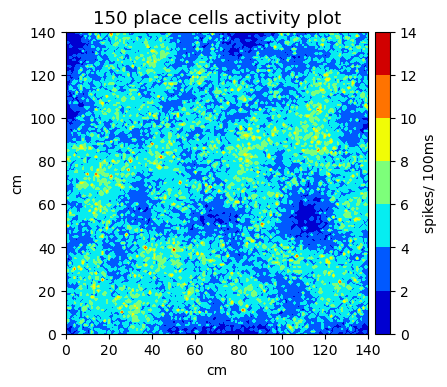

In [6]:
def plotCells(cellsList= cellsList, height = height, width = width):
    # be mindful of x and y indicies

    x_coordinates = np.arange(start=0, stop= width +1, step=1)
    y_coordinates = np.arange(start=0, stop= height +1, step=1)
    xLen, yLen = len(x_coordinates), len(y_coordinates)

    X, Y = np.meshgrid(x_coordinates, y_coordinates, indexing = 'xy')
    Z = np.zeros((yLen, xLen))

    for y in range(yLen):
        for x in range(xLen):
            location = np.array([[x_coordinates[x]],                    # important to be careful about the indexing
                                 [y_coordinates[y]]])
            
            for placeCell in cellsList:
                locationActivity = placeCell.activity(location)

                if Z[y][x] < locationActivity:
                    Z[y][x] = locationActivity

    plt.figure(dpi=100)
    plt.clf()
    plt.contourf(X, Y, Z, cmap = 'jet')
    plt.colorbar(label = 'spikes/ 100ms', pad = -0.17)
    plt.title(str(len(cellsList)) + " place cells activity plot", size = 13)
    plt.xlabel("cm")
    plt.ylabel("cm")
    plt.axis('square')
    plt.show()
    pass

plotCells()

## Color mapping

In [7]:
def colormapLocation(coordinates, height = height, width = width):

    normalizeX = clrs.Normalize(vmin = 0, vmax = width)
    normalizeY = clrs.Normalize(vmin = 0, vmax = height)
    normX, normY = normalizeX(coordinates[0,:]), normalizeY(coordinates[1,:])

    # mapX = cm.get_cmap('Blues')
    # mapY = cm.get_cmap('Reds')
    mapX = cm.get_cmap('binary')
    mapY = cm.get_cmap('spring')

    colorValues_X = mapX(normX)
    colorValues_Y = mapY(normY)
    colorValues = (colorValues_X + colorValues_Y)/2

    return colorValues

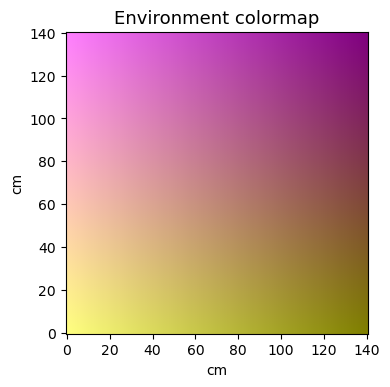

In [8]:
def plotColormapEnvironment(height = height, width = width):

    x_coordinates = np.arange(start=0, stop= width +1, step=1)
    y_coordinates = np.arange(start=0, stop= height +1, step=1)
    xLen, yLen = len(x_coordinates), len(y_coordinates)

    dataLocation = []
    for y in y_coordinates:
        for x in x_coordinates:
            location = np.array([[x],      #width
                                 [y]])     #height
            dataLocation.append(location)

    colormap = colormapLocation(np.hstack(dataLocation))
    environmentColorMap = colormap.reshape(yLen, xLen, 4)       ### I am very confused by the orther of the dimensions now

    plt.figure(dpi=100)
    plt.clf()
    plt.imshow(environmentColorMap)

    ## Run the code without the ticks. Then, it chooses strange numbers for x-axis. There is also a minor problem with 140 tick. There is originally 141 coordinates for both axes
    plt.xticks([0,20,40,60,80,100,120,140])
    plt.yticks([0,20,40,60,80,100,120,140], [140,120,100,80,60,40,20,0])

    plt.title("Environment colormap", size = 13)
    plt.xlabel("cm")
    plt.ylabel("cm")
    plt.show()
    pass

plotColormapEnvironment()

## Generating activity data

### Randomly teleporting mouse function (RandomMouse)

In [9]:
def randomMouse(cellsList, nSteps, height= height, width= width):

    data = []
    dataLocation = []
    for i in range(nSteps):
        location = np.array([[random.uniform(0,width)],
                             [random.uniform(0,height)]])
        # dataLocation.append(location)
        dataLocation.append(np.copy(location))

        sample = []
        for placeCell in cellsList:
            sample.append(placeCell.activity(location))
        data.append(np.hstack(np.copy(sample)))
        
    data = np.vstack(data)
    dataLocation = np.hstack(dataLocation)
        
    return (data, dataLocation)

In [10]:
(randomMouseData, randomMouseLocation) = randomMouse(cellsList, nSteps)

print("randomMouseData shape is " + str(randomMouseData.shape))
print("randomMouseLocation is " + str(randomMouseLocation.shape))

randomMouseData shape is (15000, 150)
randomMouseLocation is (2, 15000)


# Random Mouse Data Exploration

## PCA

In [11]:
randomZscore = zscore(randomMouseData)
randomZscore = np.nan_to_num(randomZscore)

randomMousePCA = PCA()
randomMousePCA.fit(randomZscore)

randomWeights = randomMousePCA.components_                                     # eigenvectors ordered by eigenvalues
randomVariance = randomMousePCA.explained_variance_                            # eigenvalues
randomExplainedVariance = np.cumsum(randomVariance)/np.sum(randomVariance)
randomPCA_scores = randomMousePCA.transform(randomZscore)                          #latent variables

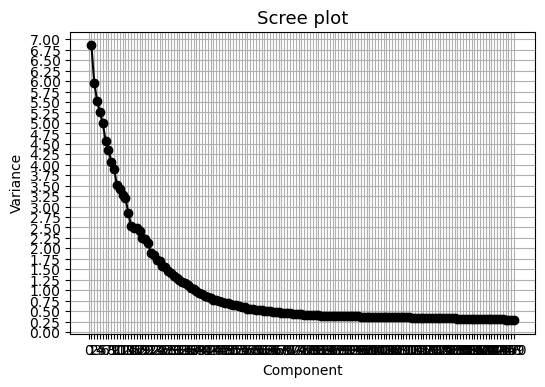

In [12]:
def plotVariance(variance):
    '''
    Plots variance (eigenvalues)
    Args:
        (numpy array of floats) : Vector of eigenvalues   ### look at the shape of the vector
    Returns:
        Nothing
    '''
    plt.figure(dpi=100, figsize=(6, 4))             # figsize=(?, 4)
    plt.clf()
    plt.plot(np.arange(1, len(variance) + 1), variance, 'o-k')

    # plt.loglog(np.arange(1, len(variance) + 1), variance, 'o-k')

    plt.title('Scree plot', size = 13)
    plt.xlabel('Component')
    plt.xticks(np.arange(0, len(variance)+1))                       ### is there a better way of doing this
    plt.ylabel('Variance')                                          ### eigenvalues
    plt.yticks(np.arange(0, max(variance)+0.25, step=0.25))
    plt.grid()
    plt.show()
    
    pass

plotVariance(randomMousePCA.explained_variance_)

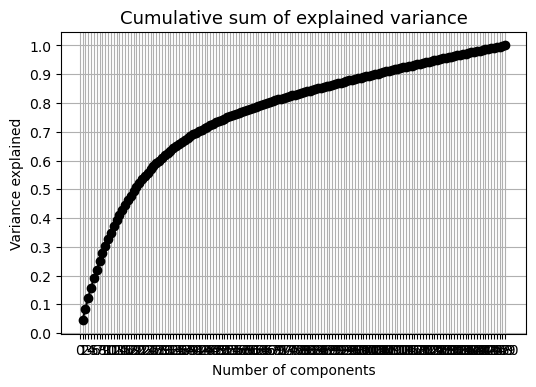

In [13]:
def plotVarianceExplained(explainedVariance):
    """
    Plots explained variance ratio
    Args:
        explainedVarianceRatio (numpy array of floats) : Vector of variance explained
                                                         for each PC
    Returns:
        Nothing.
    """
    plt.figure(dpi=100, figsize=(6, 4))
    plt.clf()
    plt.plot(np.arange(1, len(explainedVariance) + 1), explainedVariance, 'o-k')

    plt.title('Cumulative sum of explained variance', size = 13)

    plt.xlabel('Number of components')
    plt.xticks(np.arange(0, len(explainedVariance)+1))                  ### is there a better way of doing this
    plt.ylabel('Variance explained')
    plt.yticks(np.arange(0, max(explainedVariance)+0.05, step=0.1))

    plt.grid()
    plt.show()

    pass

randomExplainedVariance = np.cumsum(randomMousePCA.explained_variance_)/np.sum(randomMousePCA.explained_variance_)
plotVarianceExplained(randomExplainedVariance)

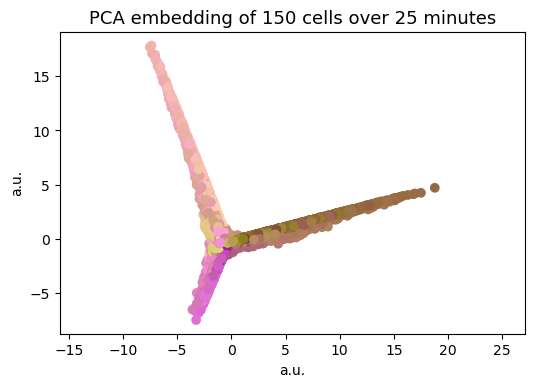

In [14]:
## plot two components

plt.figure(dpi=100)
plt.scatter(randomPCA_scores[:, 0], randomPCA_scores[:, 1], c= colormapLocation(randomMouseLocation))

plt.title(("PCA embedding of " + str(n_cells) + " cells over " + str(minutes) + " minutes"), size= 13)
plt.xlabel("a.u.")
plt.ylabel("a.u.")

plt.gca().set_aspect('equal', 'datalim')

## UMAP

In [15]:
randomReducer = umap.UMAP()     # n_neighbors=
randomUMAP_embedding = randomReducer.fit_transform(randomZscore)

print(randomUMAP_embedding.shape)

(15000, 2)


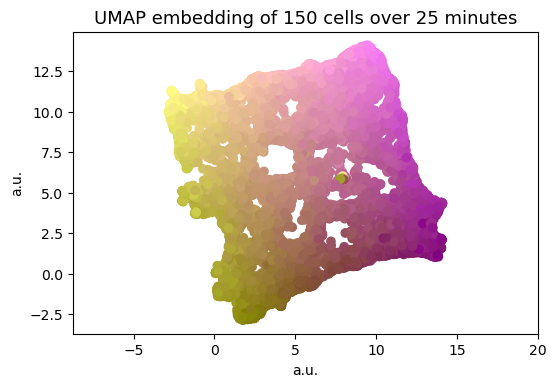

In [16]:
plt.figure(dpi=100)    # figsize=(width, height)
plt.scatter(randomUMAP_embedding[:, 0], randomUMAP_embedding[:, 1], c= colormapLocation(randomMouseLocation))

plt.title(("UMAP embedding of " + str(n_cells) + " cells over " + str(minutes) + " minutes"), size= 13)
plt.xlabel("a.u.")
plt.ylabel("a.u.")

plt.gca().set_aspect('equal', 'datalim')

In [17]:
## PCA on  master UMAP

umapZscore = zscore(randomUMAP_embedding)
umapZscore = np.nan_to_num(umapZscore)                                       ## Do I need this here?

umapMousePCA = PCA()
umapMousePCA.fit(umapZscore)

umapWeights = umapMousePCA.components_                                       # eigenvectors ordered by eigenvalues
umapVariance = umapMousePCA.explained_variance_                              # eigenvalues
umapExplainedVariance = np.cumsum(umapVariance)/np.sum(umapVariance)
umapScores = umapMousePCA.transform(umapZscore)                            # latent variables


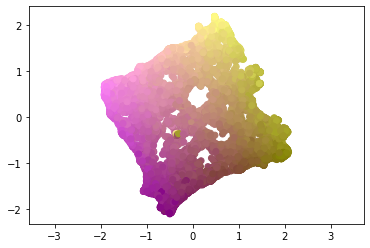

In [18]:
plt.scatter(umapScores[:, 0], umapScores[:, 1], c= colormapLocation(randomMouseLocation))
plt.gca().set_aspect('equal', 'datalim')

## Laplacian eigenmaps (spectral embedding)

In [19]:
randomLaplacian = SpectralEmbedding(n_components = 2)
randomLaplacianEmbedding = randomLaplacian.fit_transform(randomZscore)


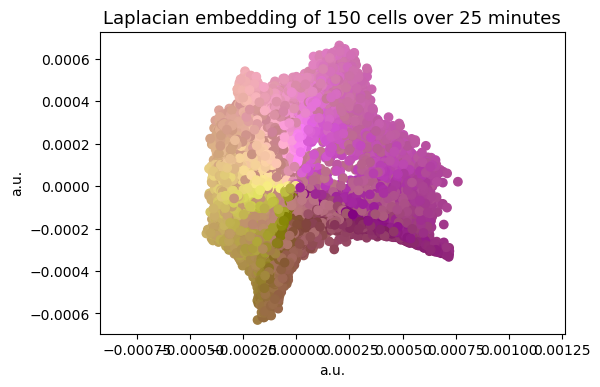

In [20]:
plt.figure(dpi=100)
plt.scatter(randomLaplacianEmbedding[:, 0], randomLaplacianEmbedding[:, 1], c= colormapLocation(randomMouseLocation))

plt.title(("Laplacian embedding of " + str(n_cells) + " cells over " + str(minutes) + " minutes"), size= 13)
plt.xlabel("a.u.")
plt.ylabel("a.u.")

plt.gca().set_aspect('equal', 'datalim')

In [21]:
# ##Save data

# Comparing distances

In [22]:
randomPCA_scores_transpose = randomPCA_scores.T[:2,:]
randomUMAP_embedding_transpose = randomUMAP_embedding.T
randomLaplacianEmbedding_transpose = randomLaplacianEmbedding.T

In [23]:
print("randomMouseLocation shape is", randomMouseLocation.shape)
print("randomPCA_scores_transpose shape is", randomPCA_scores_transpose.shape)
print("randomUMAP_embedding_transpose shape is", randomUMAP_embedding_transpose.shape)
print("randomLaplacianEmbedding_transpose shape is", randomLaplacianEmbedding_transpose.shape)

randomMouseLocation shape is (2, 15000)
randomPCA_scores_transpose shape is (2, 15000)
randomUMAP_embedding_transpose shape is (2, 15000)
randomLaplacianEmbedding_transpose shape is (2, 15000)


In [24]:
def pickRandomLocations(locations, number_of_samples= 15):
    locationsLength = locations.shape[1]

    samples = random.sample(range(locationsLength), number_of_samples)

    print("locationsLength is", locationsLength)
    print("number_of_samples is", number_of_samples)

    return samples

coordinate_indicies = pickRandomLocations(randomMouseLocation, nSteps)

locationsLength is 15000
number_of_samples is 15000


In [25]:
def distanceMeasure(coordinates, coordinate_indicies):

    locations = []
    for i in coordinate_indicies:
        locations.append(coordinates[: , i])

    locations_copy = locations.copy()
    used_locations = []
    distances = []

    for i in range(len(locations)):
        current_coordinate = locations_copy.pop(0)
        try:
            distance = np.linalg.norm(current_coordinate - used_locations[-1])
        except IndexError:
            distance = 0

        distances.append(distance)
        used_locations.append(current_coordinate)

    return distances[1:]

In [26]:
random_real_distance = distanceMeasure(randomMouseLocation, coordinate_indicies)
random_umap_distance = distanceMeasure(randomUMAP_embedding_transpose, coordinate_indicies)
random_pca_distance = distanceMeasure(randomPCA_scores_transpose, coordinate_indicies)
random_laplacian_distance = distanceMeasure(randomLaplacianEmbedding_transpose, coordinate_indicies)

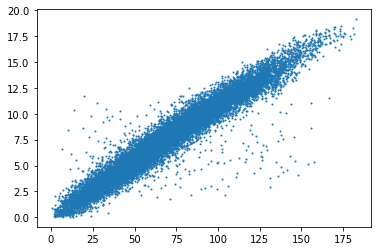

In [27]:
plt.scatter(random_real_distance, random_umap_distance, s= 1)

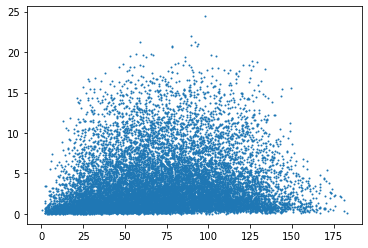

In [28]:
plt.scatter(random_real_distance, random_pca_distance, s= 1)

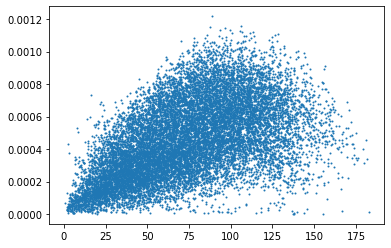

In [29]:
plt.scatter(random_real_distance, random_laplacian_distance, s= 1)

In [30]:
print(pearsonr(random_real_distance, random_umap_distance))
print(pearsonr(random_real_distance, random_pca_distance))
print(pearsonr(random_real_distance, random_laplacian_distance))

(0.961444995760677, 0.0)
(0.09551704874613501, 9.619972628100131e-32)
(0.5247773370152067, 0.0)


## Experimental script

In [31]:
def pca_function(randomZscore):

    # from sklearn.decomposition import PCA                                               # I don't have to import it here, unlike UMAP

    randomMousePCA = PCA(n_components= 2)
    randomPCA_scores = randomMousePCA.fit_transform(randomZscore)


    return randomPCA_scores

In [32]:
def umap_function(randomZscore):
    
    import umap                                                                         # for some reason I have to import it in the function
    
    randomReducer = umap.UMAP()     # n_neighbors=
    randomUMAP_embedding = randomReducer.fit_transform(randomZscore)

    # print(randomUMAP_embedding.shape)

    return randomUMAP_embedding

In [33]:
def laplacian_function(randomZscore):

    # from sklearn.manifold import SpectralEmbedding                                      # I don't have to import it here, unlike UMAP

    randomLaplacian = SpectralEmbedding(n_components= 2, n_jobs= -1)
    randomLaplacianEmbedding = randomLaplacian.fit_transform(randomZscore)

    return randomLaplacianEmbedding

## Start

In [34]:
n_cells = 50                        # number of cells to begin with
cells_addition = 30                 # number of cells to add per i loop

desired_n_samples = 5000            # number of locations to compare distances betweenIn

iLoops = 5                          # number of loops for the main loop i

jLoops = 3                          # number of experiments
kLoops = 3                          # number of time additions (+5min, max 6)

minutes = 15                        # time of the longest experiment

master_data_list = []               # list to contain all axperimental results
master_cell_list = []               # list to contain all cell lists

for i in range(1, iLoops +1):
    print("Main loop i:", i, "out of", iLoops, "initiated. Number of cells:", n_cells)
    j_data_list = []
    j_cell_list = []
    for j in range(1, jLoops +1):
        print("#" * 100)
        nSteps = minutes * 600
        print("Inner loop j:", j,"out of", jLoops, "initiated")
        cell_List = generatePlaceCells(n_cells)
        j_cell_list.append(cell_List)
        (randomMouseData, randomMouseLocation) = randomMouse(cell_List, nSteps)
        randomZscore = np.nan_to_num(zscore(randomMouseData))
        print("data generated, randomZscore(data) shape is " + str(randomZscore.shape) +", randomMouseLocation shape is " + str(randomMouseLocation.shape))

        k_data_list=[]
        time_cut = 3000
        for k in range(1, kLoops +1):
            print("_" * 100)
            lowest_data_list = []
            print("Inner loop k:", k,"out of", kLoops, "initiated")
            randomMouseLocation_cut = randomMouseLocation[:,:time_cut]
            randomZscore_cut = randomZscore[:time_cut,:]

            pca_embedding = pca_function(randomZscore_cut).T
            print("PCA done,", "pca_embedding shape is", pca_embedding.shape)

            laplacian_embedding = laplacian_function(randomZscore_cut).T
            print("Laplacian done,", "Laplaciand_embedding shape is", laplacian_embedding.shape)

            umap_embedding = umap_function(randomZscore_cut).T
            print("UMAP done,", "UMAP_embedding shape is", umap_embedding.shape)

            if time_cut < desired_n_samples:
                n_samples = time_cut
            else:
                n_samples = desired_n_samples

            coordinate_indicies = random.sample(range(time_cut), n_samples)
            real_distance = distanceMeasure(randomMouseLocation_cut, coordinate_indicies)
            pca_distance = distanceMeasure(pca_embedding, coordinate_indicies)
            laplacian_distance = distanceMeasure(laplacian_embedding, coordinate_indicies)
            umap_distance = distanceMeasure(umap_embedding, coordinate_indicies)

            real_data = [randomMouseLocation_cut, real_distance]
            lowest_data_list.append(real_data)
            pca_data = [pca_embedding, pca_distance]
            lowest_data_list.append(pca_data)
            laplacian_data = [laplacian_embedding, laplacian_distance]
            lowest_data_list.append(laplacian_data)
            umap_data = [umap_embedding, umap_distance]
            lowest_data_list.append(umap_data)

            k_data_list.append(lowest_data_list)
            time_cut += 3000

        print()

        j_data_list.append(k_data_list)
    
    master_cell_list.append(j_cell_list)
    master_data_list.append(j_data_list)
    n_cells += cells_addition

    pickle.dump(j_data_list, open("i" + str(i) + "_data_list.pickle", "wb"))
    pickle.dump(j_cell_list, open("i" + str(i) + "_cell_list.pickle", "wb"))


    print()
    print()

pickle.dump(master_cell_list, open("master_cell_list.pickle", "wb"))
pickle.dump(master_data_list, open("master_data_list.pickle", "wb"))

print("SCRIPT FINISHED SUCCESSFULLY")



Main loop i: 1 out of 5 initiated. Number of cells: 50
####################################################################################################
Inner loop j: 1 out of 3 initiated
data generated, randomZscore(data) shape is (9000, 50), randomMouseLocation shape is (2, 9000)
____________________________________________________________________________________________________
Inner loop k: 1 out of 3 initiated
PCA done, pca_embedding shape is (2, 3000)
Laplacian done, Laplaciand_embedding shape is (2, 3000)
UMAP done, UMAP_embedding shape is (2, 3000)
____________________________________________________________________________________________________
Inner loop k: 2 out of 3 initiated
PCA done, pca_embedding shape is (2, 6000)
Laplacian done, Laplaciand_embedding shape is (2, 6000)
UMAP done, UMAP_embedding shape is (2, 6000)
____________________________________________________________________________________________________
Inner loop k: 3 out of 3 initiated
PCA done, pca_embe

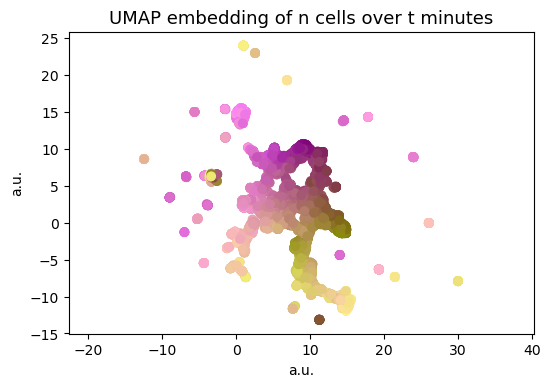

In [ ]:
data = master_data_list[4][2][2][3][0].T
color = master_data_list[4][2][2][0][0]

cells = master_cell_list[0][0]

plt.figure(dpi=100)    # figsize=(width, height)
plt.scatter(data[:, 0], data[:, 1], c= colormapLocation(color))

plt.title(("UMAP embedding of " + str("n") + " cells over " + str("t") + " minutes"), size= 13)
plt.xlabel("a.u.")
plt.ylabel("a.u.")

plt.gca().set_aspect('equal', 'datalim')

(0.6009781128802982, 0.0)


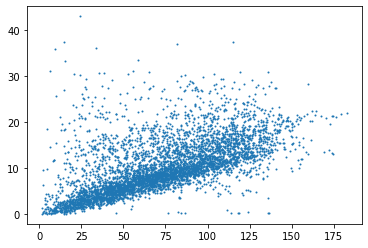

In [ ]:
real_distance = master_data_list[4][2][2][0][1]
embd_distance = master_data_list[4][2][2][3][1]


plt.scatter(real_distance, embd_distance, s= 1)
print(pearsonr(real_distance, embd_distance))


In [ ]:
len(cells)

plotCells(cells)

In [ ]:
print("i" + str(1) + "_data_list")
print("i" + str(1) + "_cell_list")

In [ ]:
# /opt/anaconda3/envs/workflow/lib/python3.10/site-packages/umap/spectral.py:260: UserWarning: WARNING: spectral initialisation failed! The eigenvector solver
# failed. This is likely due to too small an eigengap. Consider
# adding some noise or jitter to your data.

# Falling back to random initialisation!
#   warn(

In [ ]:
foo = pickle.load(open("master_data_list.pickle","rb"))

In [ ]:
data = foo[15][0][0][3][0].T
color = foo[15][0][0][0][0]

Text(0, 0.5, 'a.u.')

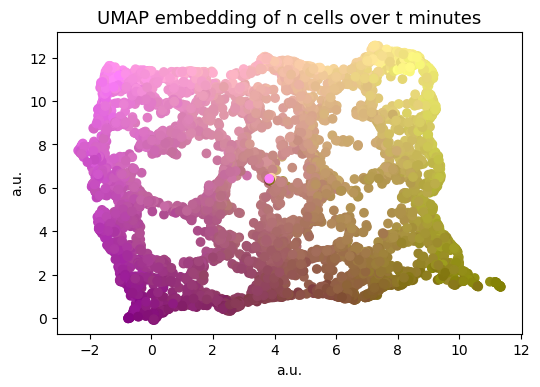

In [ ]:
data = foo[15][1][1][3][0].T
color = foo[15][1][1][0][0]

plt.figure(dpi=100)    # figsize=(width, height)
plt.scatter(data[:, 0], data[:, 1], c= colormapLocation(color))

plt.title(("UMAP embedding of " + str("n") + " cells over " + str("t") + " minutes"), size= 13)
plt.xlabel("a.u.")
plt.ylabel("a.u.")
